<a href="https://colab.research.google.com/github/Ansebi/causal_inference/blob/kls/BAMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install bamt

Exception in thread Thread-5 (attachment_entry):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 237, in listen
    sock, _ = endpoints_listener.accept()
  File "/usr/lib/python3.10/socket.py", line 293, in accept
    fd, addr = self._accept()
TimeoutError: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy.py", line 52, in attachment_entry
    debugpy.listen(_dap_port)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/public_api.py", line 31, in wrapper
    return wrapped(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 143, in debug
    log.reraise

In [2]:
import bamt.networks as networks
import bamt.preprocessors as pp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split

from pgmpy.estimators import K2Score, BicScore, BDeuScore, StructureScore

# Data

In [4]:
def normalize(
    array: np.array,
    min_: float = None,
    max_: float = None
):
  if len(np.unique(array)) == 1:
    value = np.unique(array)[0]
    norm_value = 0.5
    if max_ != min_:
      norm_value = (value - min_) / (max_ - min_)
    return np.ones_like(array) * norm_value
  if min_ is None:
    min_ = array.min()
  if max_ is None:
    max_ = array.max()
  return (array - min_) / (max_ - min_)

In [ ]:
df = pd.read_csv("PYATEROCHKA L7_Центральный_BEVERAGE.csv", sep=';')
df = df.dropna()
# df = df.head(3000)
# df = df.drop(columns=['CALDR_DT', 'period_CALDR_DT_first', 'period_CALDR_DT_last', 'PROD_MAP'])
# df = df.astype(float)
# df = df.apply(normalize)

In [ ]:
df.head(1)

,magnitude,depends_on_magnitude,switch,garbage_0,garbage_1,garbage_2,outcome
0,4,40.067909,1,0.388792,0.197747,0.548344,41.137917


In [ ]:
df.shape

(28563, 13)

In [ ]:
N_GARBAGE = 3

a = 10
b = 1.6
c_prime = 0.5

i_m = 3
i_y = 1

magnitude = np.random.randint(0, 9, 1000)
depends_on_magnitude = magnitude * a + i_m + np.random.rand(len(magnitude)) / 10
outcome = b * depends_on_magnitude + c_prime * magnitude + i_y + np.random.rand(len(magnitude)) / 10

switch = np.ones_like(magnitude)
garbage = {f'garbage_{i}': np.random.random(len(magnitude)) for i in range(N_GARBAGE)}

df = pd.DataFrame(
    {
        'magnitude': magnitude,
        'depends_on_magnitude': depends_on_magnitude,
        'switch': switch,
        **garbage,
        'outcome': outcome
    }
)

df_norm = df.copy()
for column in df:
  df_norm[column] = normalize(df_norm[column])
df_norm = df_norm.fillna(0.5)
df_norm.head()

,magnitude,depends_on_magnitude,switch,garbage_0,garbage_1,garbage_2,outcome
0,0.000,0.000117,0.5,0.766542,0.698907,0.144980,0.000327
1,0.000,0.000246,0.5,0.544610,0.374002,0.230418,0.000582
2,0.875,0.874314,0.5,0.000000,0.932816,0.278217,0.874495
3,0.375,0.375729,0.5,0.007449,0.671679,0.645483,0.375919
4,0.625,0.625396,0.5,0.610164,0.015619,0.446450,0.625303


In [ ]:
# DANGER! OVERKILL HAZARD

import random

N_SAMPLES = 10000
N_GARBAGE = 5


source_a = np.random.randint(-100, -10, N_SAMPLES)
source_b = np.random.randint(0, 100, N_SAMPLES)
source_c = np.random.random(N_SAMPLES)


chain_a0 = np.ones(N_SAMPLES)
chain_b0 = np.ones(N_SAMPLES)
chain_c0 = np.ones(N_SAMPLES)

for i in range(N_SAMPLES):
  if source_a[i] >= -30:
    value = 5
  elif source_a[i] <= -70:
    value = 7
  else:
    value = np.sin(source_a[i])
  chain_a0[i] = value

for i in range(N_SAMPLES):
  if source_b[i] < 5:
    value = np.sin(source_b[i]) ** 2
  elif source_b[i] == 5:
    value = 2 * source_b[i]
  else:
    value = 1 / max([source_b[i],  1])
  chain_b0[i] = value

for i in range(N_SAMPLES):
  if source_c[i] < 0.5:
    value = (source_c[i] - 1) * 2
  else:
    value = source_c[i] / (np.cos(source_c[i]) - 1.1)
  chain_c0[i] = value


chain_a1 = np.ones(N_SAMPLES)
chain_b1 = np.ones(N_SAMPLES)
chain_c1 = np.ones(N_SAMPLES)

for i in range(N_SAMPLES):
  value = chain_a0[i]
  if '2' in str(round(value, 3)):
    value = np.sin(value)
  elif sum([int(char) for char in str(np.abs(value)).replace('.', '')]) % 2:
    value = 0.35
  else:
    value = 1 / min([value, 0.1])
  chain_a1[i] = value

for i in range(N_SAMPLES):
  value = chain_b0[i]
  if value > 0.8:
    value = np.tan(value)
  elif np.sin(value) > 0.5:
    value = -0.12
  else:
    value = (1 / min([value, -1])) ** 2
  chain_b1[i] = value

for i in range(N_SAMPLES):
  value = chain_c0[i]
  if value < 0:
    value = np.tan(value)
  else:
    value = 6
  chain_c1[i] = value


outcome = chain_a1 + chain_b1 + chain_c1

garbage = {
    f'garbage_{i}': random.choice(
        [
            np.random.randint(0, 9, N_SAMPLES),
            np.random.randint(0, 100, N_SAMPLES),
            np.random.random(N_SAMPLES)
        ]
    )
    for i in range(N_GARBAGE)
}

df_overkill = pd.DataFrame(
    {
      'source_a': source_a,
      'chain_a0': chain_a0,
      'chain_a1': chain_a1,
      'source_b': source_b,
      'chain_b0': chain_b0,
      'chain_b1': chain_b1,
      'source_c': source_c,
      'chain_c0': chain_c0,
      'chain_c1': chain_c1,
      'outcome': outcome,
      **garbage
    }
)

df = df_overkill.astype(float)
df.head()

,source_a,chain_a0,chain_a1,source_b,chain_b0,chain_b1,source_c,chain_c0,chain_c1,outcome,garbage_0,garbage_1,garbage_2,garbage_3,garbage_4
0,-74.0,7.000000,0.350000,72.0,0.013889,1.0,0.850237,-1.931501,2.651057,4.001057,46.0,0.341538,5.0,0.634376,1.0
1,-71.0,7.000000,0.350000,82.0,0.012195,1.0,0.307441,-1.385117,-5.323603,-3.973603,33.0,0.811882,7.0,0.218469,2.0
2,-59.0,-0.636738,0.350000,73.0,0.013699,1.0,0.849484,-1.932273,2.644875,3.994875,50.0,0.770413,5.0,0.303429,5.0
3,-32.0,-0.551427,-1.813478,26.0,0.038462,1.0,0.896343,-1.884937,3.077881,2.264404,63.0,0.230758,0.0,0.092207,4.0
4,-26.0,5.000000,0.350000,47.0,0.021277,1.0,0.402186,-1.195627,-2.539218,-1.189218,77.0,0.221024,3.0,0.382196,3.0


In [ ]:
N_GARBAGE = 3
# magnitude = np.array([1, 7, 9, 2, 1] * 10)
magnitude = np.random.randint(0, 9, 100)

depends_on_magnitude = magnitude * 10 + np.random.rand(len(magnitude)) / 10
switch = np.ones_like(magnitude)
garbage = {f'garbage_{i}': np.random.random(len(magnitude)) for i in range(N_GARBAGE)}
outcome = depends_on_magnitude + 1 + np.random.rand(len(magnitude)) / 10
df = pd.DataFrame(
    {
        'magnitude': magnitude,
        'depends_on_magnitude': depends_on_magnitude,
        'switch': switch,
        **garbage,
        'outcome': outcome
    }
)

df_norm = df.copy()
for column in df:
  df_norm[column] = normalize(df_norm[column])
df_norm = df_norm.fillna(0.5)
df_norm.head()

,magnitude,depends_on_magnitude,switch,garbage_0,garbage_1,garbage_2,outcome
0,1.000,1.000000,0.5,0.066362,0.426638,0.079576,0.999222
1,0.250,0.250237,0.5,0.080092,0.240816,0.879698,0.251037
2,0.750,0.749198,0.5,0.502976,0.530594,0.914671,0.749422
3,0.125,0.125002,0.5,0.711248,0.659527,0.685446,0.125311
4,0.250,0.250543,0.5,0.594303,0.539926,0.226967,0.250427


In [19]:
N_GARBAGE = 3
LAG = 0
# past = np.array([1, 7, 9, 2, 1])
# past = np.array([1, 7, 9, 2, 1] * 10)
past = np.random.randint(0, 9, 1000)
future = np.zeros_like(past).astype(float)
for i in range(len(past)):
    if i - LAG >= 0:
        value = past[i-LAG] * 2 + (np.random.random() - 1) * 1e-1
    else:
        value = np.random.randint(0, 9)
    future[i] = value
garbage = {f'garbage_{i}': np.random.randint(0, 9, len(past)) for i in range(N_GARBAGE)}

df = pd.DataFrame(
    {
        'past': past,
        'future': future,
        **garbage
    }
)
df = df.apply(normalize)
df.head(15)

,past,future,garbage_0,garbage_1,garbage_2
0,1.000,0.996606,0.250,0.500,0.000
1,0.250,0.251241,0.250,0.250,0.000
2,0.000,0.005354,0.250,0.250,0.750
3,1.000,0.997090,0.500,0.625,1.000
4,0.000,0.003681,0.625,0.375,0.250
5,0.250,0.252012,0.375,0.125,1.000
6,0.875,0.872954,0.375,0.500,0.125
7,0.625,0.622041,0.250,0.000,0.250
8,0.250,0.254524,0.750,0.375,0.625
9,0.625,0.623571,0.625,0.125,1.000


In [ ]:
df_norm = df.apply(normalize)

In [ ]:
df_norm.head()

,source_a,chain_a0,chain_a1,source_b,chain_b0,chain_b1,source_c,chain_c0,chain_c1,outcome,garbage_0,garbage_1,garbage_2,garbage_3,garbage_4
0,0.292135,1.000000,0.183136,0.727273,0.001389,0.928321,0.850252,0.253614,0.051347,0.051339,0.464646,0.341554,0.625,0.634351,0.125
1,0.325843,1.000000,0.183136,0.828283,0.001220,0.928321,0.307431,0.691485,0.050982,0.050974,0.333333,0.811929,0.875,0.218399,0.250
2,0.460674,0.045397,0.183136,0.737374,0.001370,0.928321,0.849500,0.252996,0.051347,0.051338,0.505051,0.770457,0.625,0.303368,0.625
3,0.764045,0.056061,0.000000,0.262626,0.003846,0.928321,0.896360,0.290931,0.051367,0.051259,0.636364,0.230767,0.000,0.092124,0.500
4,0.831461,0.749997,0.183136,0.474747,0.002128,0.928321,0.402180,0.843342,0.051110,0.051101,0.777778,0.221033,0.375,0.382144,0.375


In [ ]:
data_train, data_test = train_test_split(df_norm, test_size=0.2, random_state=42)

target_test = data_test['outcome']
data_test = data_test.drop(columns=['outcome'])

In [ ]:
target_test

6252    0.844459
4684    0.846536
1731    0.846303
4742    0.846467
4521    0.846521
          ...   
6412    0.846728
8285    0.845927
7853    0.846359
1095    0.846440
6929    0.848660
Name: outcome, Length: 2000, dtype: float64

# Analysis

In [ ]:
df.describe()

,volume_aggregate,single_price,single_discount,price_rolling_vote,price_fill,label,period_single_price_mean,period_single_price_std,period_capped_volume_sum,period_capped_volume_std,period_duration,period_avg_daily_volume,pricing
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,4647.44900,47.668820,34.001971,47.668820,47.668820,124.382000,47.668820,0.0,46373.96600,5.376708,8.805000,4636.560706,0.000177
std,4434.24527,11.971572,18.623521,11.971572,11.971572,65.327159,11.971572,0.0,35992.77122,1.770190,4.730047,2574.441326,0.003027
min,6.00000,24.450000,0.000000,24.450001,24.450001,0.000000,24.450001,0.0,12.00000,0.000000,1.000000,12.000000,0.000000
25%,1810.50000,39.900002,20.517481,39.900002,39.900002,69.000000,39.900002,0.0,20196.00000,4.103820,5.000000,2858.031250,0.000000
50%,3564.00000,44.295000,44.115944,44.295000,44.295000,124.000000,44.295000,0.0,35616.00000,5.133743,9.000000,4397.800000,0.000000
75%,6091.50000,59.820000,46.881115,59.820000,59.820000,183.000000,59.820000,0.0,74598.00000,7.021878,12.000000,6690.600000,0.000000
max,40770.00000,66.500000,66.506851,66.500000,66.500000,226.000000,66.500000,0.0,145668.00000,12.727922,19.000000,11398.000000,0.062500


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 0 to 3359
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   volume_aggregate          3000 non-null   float64
 1   single_price              3000 non-null   float64
 2   single_discount           3000 non-null   float64
 3   price_rolling_vote        3000 non-null   float64
 4   price_fill                3000 non-null   float64
 5   label                     3000 non-null   int64  
 6   period_single_price_mean  3000 non-null   float64
 7   period_single_price_std   3000 non-null   float64
 8   period_capped_volume_sum  3000 non-null   int64  
 9   period_capped_volume_std  3000 non-null   float64
 10  period_duration           3000 non-null   int64  
 11  period_avg_daily_volume   3000 non-null   float64
 12  PROD_MAP                  3000 non-null   object 
 13  pricing                   3000 non-null   float64
dtypes: float64(10

,magnitude,depends_on_magnitude,switch,garbage_0,garbage_1,garbage_2,outcome
1,7,70.074641,1,0.173798,0.879376,0.274203,71.089909
6,7,70.008166,1,0.740875,0.367516,0.470590,71.053126
11,7,70.099345,1,0.747112,0.759355,0.420824,71.192264
16,7,70.026922,1,0.822999,0.681778,0.567250,71.049105
21,7,70.009269,1,0.938676,0.905978,0.175696,71.044695


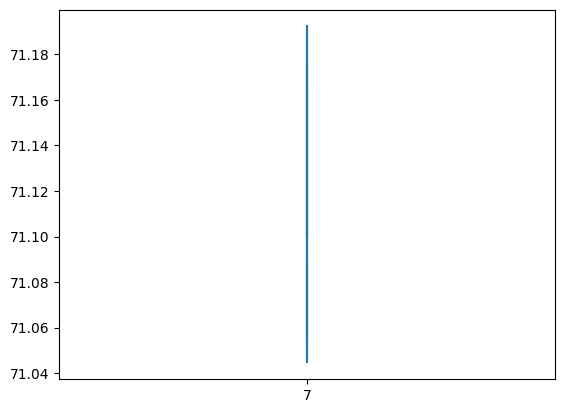

In [ ]:
df_70 = df.query('depends_on_magnitude >= 69 and depends_on_magnitude <= 81').sort_values('magnitude')
plt.plot(df_70.magnitude, df_70.outcome)
df_70.head()

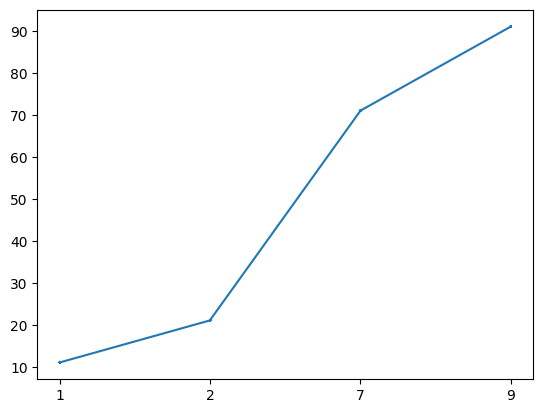

In [ ]:
plt.plot(df.sort_values('magnitude').magnitude, df.sort_values('magnitude').outcome)

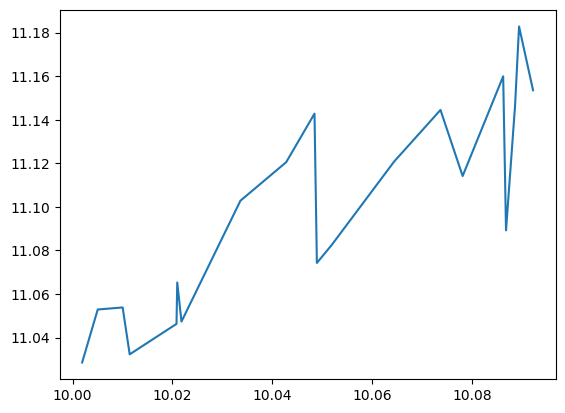

In [ ]:
df_1 = df.query('magnitude == "1"').sort_values('depends_on_magnitude')
plt.plot(df_1.depends_on_magnitude, df_1.outcome)

# Composite BN

In [ ]:
# CompositeBN
encoder = preprocessing.LabelEncoder()
p = pp.Preprocessor([("encoder", encoder)])

preprocessed_data, _ = p.apply(df)

bn = networks.CompositeBN()

info = p.info

bn.add_nodes(info)

bn.add_edges(df) # !!! non-preprocessed

bn.fit_parameters(df) # !!! non-preprocessed
bn.get_info()


Generations:   0%|          | 0/50 [00:00<?, ?gen/s]

2024-03-13 12:05:55,321 | INFO     | log.py-log-0193 | MultiprocessingDispatcher - Number of used CPU's: 2
2024-03-13 12:05:55,321 - MultiprocessingDispatcher - Number of used CPU's: 2
2024-03-13 12:06:01,075 | CRITICAL | log.py-log-0193 | MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2024-03-13 12:06:01,075 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2024-03-13 12:06:01,104 | INFO     | log.py-log-0193 | EvoGraphOptimizer - Generation num: 1 size: 1
2024-03-13 12:06:01,104 - EvoGraphOptimizer - Generation num: 1 size: 1
2024-03-13 12:06:01,117 | INFO     | log.py-log-0193 | EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<custom=nan>']
2024-03-13 12:06:01,117 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<custom=nan>']
2024-03-13 12:06:01,132 | INFO     | log.py-log-0193 | EvoGraphOptimizer - no improvements for 1 ite

Generations:   0%|          | 0/50 [02:58<?, ?gen/s]

2024-03-13 12:08:53,437 | INFO     | log.py-log-0193 | OptimisationTimer - Composition time: 2.969 min
2024-03-13 12:08:53,437 - OptimisationTimer - Composition time: 2.969 min


KeyboardInterrupt: 

In [ ]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,T,Gaussian (LinearRegression),cont,[],[]
1,K,Gaussian (LinearRegression),cont,[],[]
2,H,Gaussian (LinearRegression),cont,[],[]
3,A,Gaussian (LinearRegression),cont,[],[]
4,Z,Gaussian (LinearRegression),cont,[],[]
5,X,Gaussian (LinearRegression),cont,[],[]
6,N,Gaussian (LinearRegression),cont,[],[]
7,V,Gaussian (LinearRegression),cont,[],[]
8,Q,Gaussian (LinearRegression),cont,[],[]
9,W,Gaussian (LinearRegression),cont,[],[]


In [ ]:
bn.plot('bn.html')

# Preprocessing

In [20]:
encoder = preprocessing.LabelEncoder()
discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

p = pp.Preprocessor([('encoder', encoder), ('discretizer', discretizer)])
discretized_data, est = p.apply(df)


2024-03-25 12:29:14,511 | INFO     | preprocessors.py-scan-0107 | No one column is discrete


In [21]:
print(p.info)
for col in discretized_data.columns:
	  print(col, discretized_data[col].dtype)

{'types': {'past': 'cont', 'future': 'cont', 'garbage_0': 'cont', 'garbage_1': 'cont', 'garbage_2': 'cont'}, 'signs': {'past': 'pos', 'future': 'pos', 'garbage_0': 'pos', 'garbage_1': 'pos', 'garbage_2': 'pos'}}
past int64
future int64
garbage_0 int64
garbage_1 int64
garbage_2 int64


In [22]:
discretized_data.head()

,past,future,garbage_0,garbage_1,garbage_2
0,4,4,1,2,0
1,1,1,1,1,0
2,0,0,1,1,3
3,4,4,2,3,4
4,0,0,3,2,1


In [23]:
discretized_data.shape

(1000, 5)

# bnlearn

imports

In [ ]:
!pip install bnlearn

In [ ]:
!pip install d3blocks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.5
    Uninstalling MarkupSafe-2.1.5:
      Successfully uninstalled MarkupSafe-2.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
werkzeug 3.0.1 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [ ]:
import pandas as pd

data

In [ ]:
discretized_data.to_csv('discretized_data_simple_100.csv')

In [ ]:
discretized_data = pd.read_csv('discretized_data_simple_100.csv').iloc[:,1:]
discretized_data.head()

,magnitude,depends_on_magnitude,switch,garbage_0,garbage_1,garbage_2,outcome
0,4,4,0,0,2,0,4
1,1,1,0,0,1,4,1
2,3,3,0,2,2,4,3
3,0,0,0,3,3,3,0
4,1,1,0,3,2,1,1


learn

In [ ]:
import bnlearn as bn

data_bn = discretized_data.copy()
for col in data_bn.columns:
	data_bn[col] = data_bn[col].astype(str)
data_bn.dtypes

# обучение структуры: bic быстрее
DAG_bnlearn = bn.structure_learning.fit(data_bn, methodtype="hc", scoretype="k2")
# DAG_bnlearn = bn.structure_learning.fit(data_bn, methodtype="hc", scoretype="bic")
# DAG_bnlearn = bn.structure_learning.fit(data_bn, methodtype="hc", scoretype="bdeu", verbose=5)

# Свойства графа
DAG_bnlearn_edges = bn.get_edge_properties(DAG_bnlearn)
# Матрица сопряжённости
print(DAG_bnlearn['adjmat'])

# обучение параметров (весов)
DAG_bnlearn_params = bn.parameter_learning.fit(DAG_bnlearn, data_bn, methodtype='maximumlikelihood')

# Рисуем граф
DAG_bnlearn_plot = bn.plot(DAG_bnlearn, interactive=True)

# Сохряняем
# with open(f'{resultsdir}bnlearn.pickle', 'wb') as f:
# 	pickle.dump((DAG_bnlearn, DAG_bnlearn_params), f)

# with open(f'{resultsdir}bnlearn.pickle', 'rb') as f:
# 	(DAG_bnlearn, DAG_bnlearn_params) = pickle.load(f)


[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [k2]
[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Set edge properties.
target                magnitude  depends_on_magnitude  switch  garbage_0  \
source                                                                     
magnitude                 False                  True   False      False   
depends_on_magnitude      False                 False   False      False   
switch                    False                 False   False      False   
garbage_0                 False                 False   False      False   
garbage_1                 False                 False   False      False   
garbage_2                 False                 False   False      False   
outcome                   False                 False   False      False   

target                garbage_1  garbage_2  outcome  
source                                               
magnitude            

[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Converting source-target into adjacency matrix..
[d3blocks] >INFO> Making the matrix symmetric..
[d3blocks] >INFO> Set directed=True to see the markers!
[d3blocks] >INFO> Keep only edges with weight>0
[d3blocks] >INFO> Converting source-target into adjacency matrix..
[d3blocks] >INFO> Making the matrix symmetric..
[d3blocks] >INFO> Converting adjacency matrix into source-target..
[d3blocks] >INFO> Number of unique nodes: 5
[d3blocks] >INFO> Slider range is set to [0, 1]
[d3blocks] >INFO> Write to path: [/tmp/tmp41mfkx20/d3graph.html]
[d3blocks] >INFO> File already exists and will be overwritten: [/tmp/tmp41mfkx20/d3graph.html]
[d3blocks] >INFO> Keep only edges with weight>0
[d3blocks] >INFO> Converting source-target into adjacency matrix..
[d3blocks] >INFO> Making the matrix symmetric..
[d3blocks] >INFO> Number of unique nodes: 5
[d3blocks] >INFO> Slider range is set to [0, 1]
[d3blocks] >INFO> Write t

[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


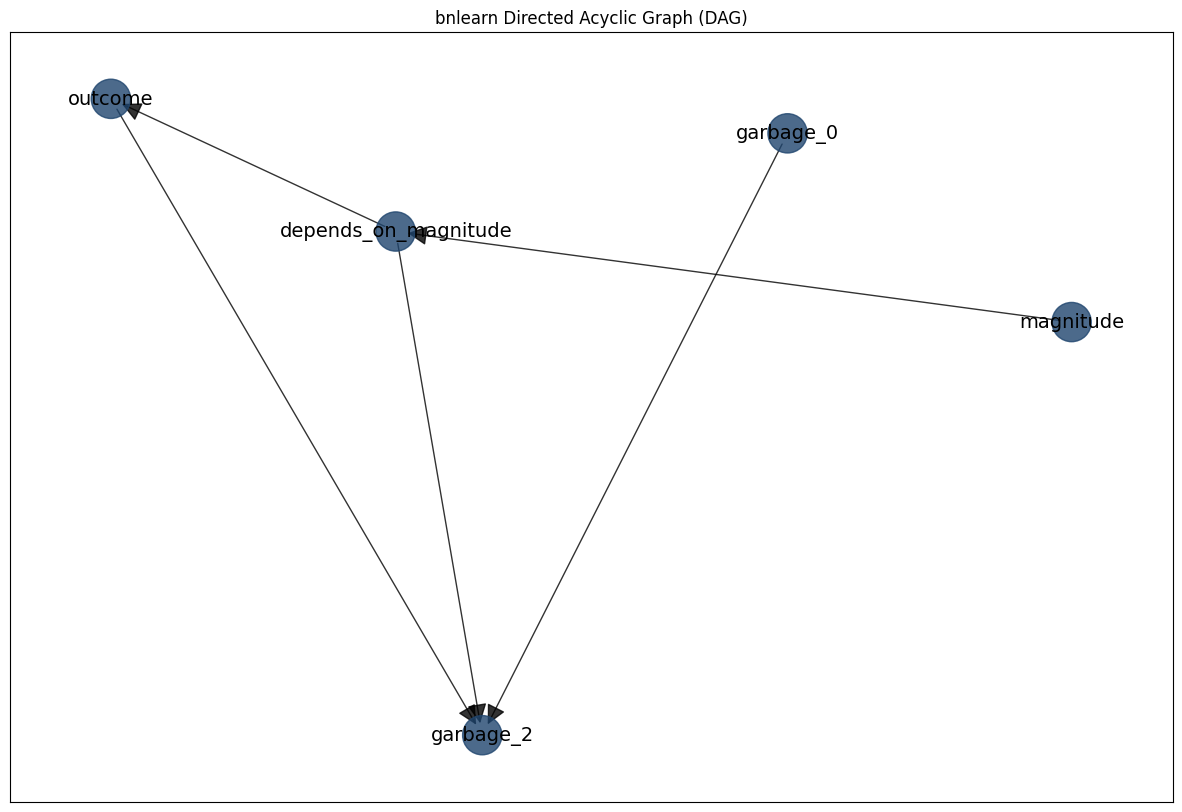

In [ ]:
G = bn.plot(DAG_bnlearn)

[bnlearn] >Compute edge strength with [chi_square]
[bnlearn] >Set node properties.
[bnlearn]> Set edge weights based on the [chi_square] test statistic.
[bnlearn] >Converting source-target into adjacency matrix..
[bnlearn] >Making the matrix symmetric..
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


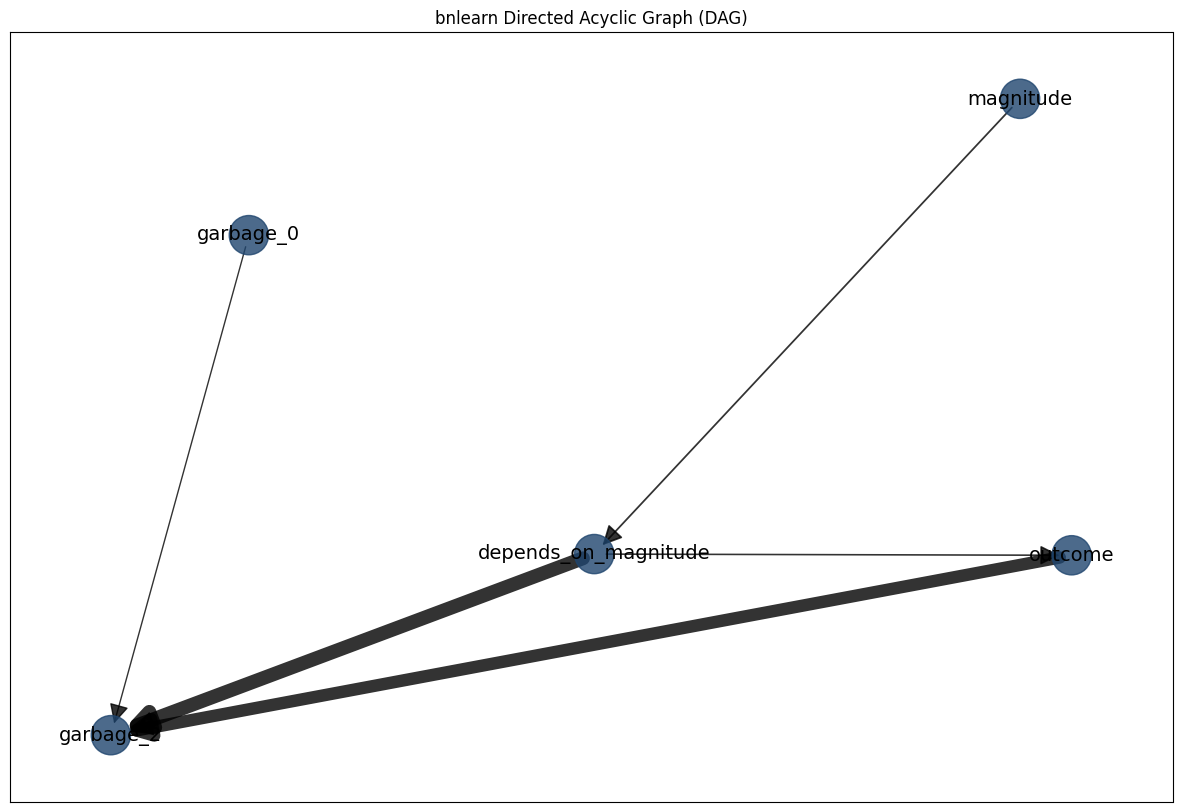

{'fig': <Figure size 1500x1000 with 1 Axes>,
 'ax': <Figure size 1500x1000 with 1 Axes>,
 'pos': {'magnitude': array([-0.1634499 ,  0.24365867]),
  'depends_on_magnitude': array([-0.31483342, -0.10026359]),
  'switch': array([ 0.54769356, -0.31695879]),
  'garbage_0': array([-0.43762034,  0.14065845]),
  'garbage_1': array([1.        , 0.37116112]),
  'garbage_2': array([-0.48667071, -0.23708165]),
  'outcome': array([-0.14511919, -0.1011742 ])},
 'G': <networkx.classes.digraph.DiGraph at 0x7b77f50089d0>,
 'node_properties': {'magnitude': {'node_color': '#1f456e', 'node_size': 800},
  'depends_on_magnitude': {'node_color': '#1f456e', 'node_size': 800},
  'switch': {'node_color': '#1f456e', 'node_size': 800},
  'garbage_0': {'node_color': '#1f456e', 'node_size': 800},
  'garbage_1': {'node_color': '#1f456e', 'node_size': 800},
  'garbage_2': {'node_color': '#1f456e', 'node_size': 800},
  'outcome': {'node_color': '#1f456e', 'node_size': 800}},
 'edge_properties': {('depends_on_magnitude

In [ ]:
model1 = bn.independence_test(DAG_bnlearn, data_bn, alpha=0.05, prune=False)
bn.plot(model1)#, pos=G['pos'])

In [ ]:
# Access the CPT of a specific node
node_cpt = DAG_bnlearn_params['params']#['YourNodeName']  # replace 'YourNodeName' with your actual node name

# Print the CPT
print(node_cpt)


KeyError: 'params'

In [ ]:
DAG_bnlearn_params#.keys()

{'model': <pgmpy.models.BayesianNetwork.BayesianNetwork at 0x7b77f55e3ac0>,
 'adjmat': target                magnitude  depends_on_magnitude  switch  garbage_0  \
 source                                                                     
 magnitude                 False                  True   False      False   
 depends_on_magnitude      False                 False   False      False   
 switch                    False                 False   False      False   
 garbage_0                 False                 False   False      False   
 garbage_1                 False                 False   False      False   
 garbage_2                 False                 False   False      False   
 outcome                   False                 False   False      False   
 
 target                garbage_1  garbage_2  outcome  
 source                                               
 magnitude                 False      False    False  
 depends_on_magnitude      False       True     True  

In [ ]:
DAG_bnlearn_params['independence_test']

viz

In [ ]:
import os

# List all files in the directory
files = os.listdir('/tmp/tmpymobycjd/')
print(files)


['bnlearn_Directed_Acyclic_Graph_(DAG).html']


In [ ]:
from google.colab import files

# Specify the path to the file
file_path = "/tmp/tmpymobycjd/bnlearn_Directed_Acyclic_Graph_(DAG).html"  # replace "your_file.txt" with your actual file name

# Download the file
files.download(file_path)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Structure learning

In [24]:
bn = networks.ContinuousBN(use_mixture=True) # init BN
# bn = networks.HybridBN(has_logit=True, use_mixture=True) # init BN
# bn = networks.DiscreteBN() # init BN


info = p.info
bn.add_nodes(info)

In [ ]:
# params = {
#             # Defines initial nodes of the network, list of node names
#            'init_nodes':[...]
#             # Defines initial edges of the network, list of tuples (node1, node2)
#            'init_edges':[...]
#            # Strictly set edges where algoritm must learn, list of tuples (node1, node2)
#            'white_list':[...]
#            # blacklist edges, list of tuples (node1, node2)
#            'bl_add':[...]
#            # Allow algorithm to remove edges defined by user, bool
#            'remove_init_edges':True
#           }

In [25]:
bn.add_edges(discretized_data,  scoring_function=('K2', K2Score))


# bn.add_edges(discretized_data, scoring_function=("BIC", BicScore))
# bn.add_edges(discretized_data, scoring_function=("BDeu", BDeuScore))
# bn.add_edges(discretized_data, scoring_function=("Structure", StructureScore))

# эволюционный алгоритм
# bn.add_edges(discretized_data, optimizer='Evo')



  0%|          | 0/1000000 [00:00<?, ?it/s]

In [26]:
info

{'types': {'past': 'cont',
  'future': 'cont',
  'garbage_0': 'cont',
  'garbage_1': 'cont',
  'garbage_2': 'cont'},
 'signs': {'past': 'pos',
  'future': 'pos',
  'garbage_0': 'pos',
  'garbage_1': 'pos',
  'garbage_2': 'pos'}}

In [27]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,past,MixtureGaussian,cont,[],[]
1,garbage_0,MixtureGaussian,cont,[],[]
2,garbage_1,MixtureGaussian,cont,[],[]
3,garbage_2,MixtureGaussian,cont,[],[]
4,future,MixtureGaussian,cont,[past],[cont]


In [28]:
bn.calculate_weights(discretized_data)

In [29]:
bn.weights

{('past', 'future'): 0.6768195232247156}

# WeightTreeCreating

In [ ]:
import copy
def chain_from_bamt_bn_weights(
    bamt_bn_weights,
    outcome_column_name: str,
    top_n: int,
    influence_threshold: float = 0.1,
    depth=None,
    branch=None,
    chain=None
):
  if chain is None:
    chain = {}
  if depth is None:
    depth = 0
  if branch is None:
    branch = 0

  df_influence = pd.DataFrame(columns=['influence'])
  bamt_bn_weights_ = copy.copy(bamt_bn_weights)

  for components, influence in bamt_bn_weights.items():
    if outcome_column_name in components:
      del bamt_bn_weights_[components]
      pair_component = (set(components) - set([outcome_column_name])).pop()
      df_influence.loc[pair_component] = influence
  if df_influence.empty:
    return chain
  df_influence = df_influence.sort_values('influence', ascending=False)
  actors = None
  if influence_threshold is None:
    actors = list(df_influence.head(top_n).index)
  else:
    query = df_influence.query('influence >= @influence_threshold')
    if not query.empty:
      query = query.head(top_n)
      actors = list(query.index)
  chain[f'{depth}_{branch}::{outcome_column_name}'] = df_influence
  if actors is not None:
    for branch, actor in enumerate(actors):
      weights_to_go = copy.copy(bamt_bn_weights_)
      for other_actor in actors:
        for components in bamt_bn_weights_.keys():
          if (other_actor != actor) and (other_actor in components):
            if components in weights_to_go:
              del weights_to_go[components]

      chain = chain_from_bamt_bn_weights(
          weights_to_go,
          actor,
          top_n,
          influence_threshold,
          depth + 1,
          branch,
          chain
      )
  return chain



def interpret_chain(chain, influence_threshold: float = 0.1):
  interpreted_chain = {}
  for name, df_influence in chain.items():
    query = df_influence.query('influence >= @influence_threshold')
    if not query.empty:
      interpreted_chain[name] = []
      for actor, row in query.iterrows():
        interpreted_chain[name].append((actor, row['influence']))
  return interpreted_chain


"""
e.g.
interpret_chain(
  chain=chain_from_bamt_bn_weights(bamt_bn_weights, 'outcome', 3, 0.1),
  influence_threshold=0.1
)
"""

"\ne.g.\ninterpret_chain(\n  chain=chain_from_bamt_bn_weights(bamt_bn_weights, 'outcome', 3, 0.1),\n  influence_threshold=0.1\n)\n"

In [ ]:
interpret_chain(
  chain=chain_from_bamt_bn_weights(bn.weights, 'outcome', 1, 0.01),
  influence_threshold=0.01
)

{'0_0::outcome': [('depends_on_magnitude', 0.7590011098616545),
  ('magnitude', 0.7401386957995995),
  ('garbage_2', 0.17032773369992427)]}

In [ ]:
def weights_from_bamt(weights):
    chain = {}
    for key, value in weights.items():
        frame_for_first = pd.DataFrame(index=[key[1]], data=[value], columns=['influence'])
        frame_for_second = pd.DataFrame(index=[key[0]], data=[value], columns=['influence'])

        if chain.get(key[0]) is None:
            chain[key[0]] = frame_for_first
        else:
            chain[key[0]] = pd.concat([chain[key[0]], frame_for_first])

        if chain.get(key[1]) is None:
            chain[key[1]] = frame_for_second
        else:
            chain[key[1]] = pd.concat([chain[key[1]], frame_for_second])

    return chain

In [ ]:
chain = weights_from_bamt(bn.weights)

In [ ]:
len(chain)

10

In [ ]:
chain['outcome']

,influence
chain_a1,0.353916
chain_b1,0.011493
chain_c0,0.346776
chain_c1,0.418272


In [ ]:
def tree(tree_dict):

    # Создаем граф из словаря
    graph = {}
    for key, value in tree_dict.items():
        parent, child = key
        if parent not in graph:
            graph[parent] = []
        graph[parent].append((child, value))


    # Сортировка детей
    for node, children in graph.items():
        sorted_children = sorted(children, key=lambda x: x[1], reverse=True)
        graph[node] = sorted_children


    # Поиск всех детей
    all_children = set()
    for node, children in graph.items():
        for child, _ in children:
            all_children.add(child)


    # Поиск корней
    sorted_graph = {}
    for node, children in graph.items():
        if node not in all_children:
            sorted_graph[node] = children

    # Финальная сортировка
    sorted_graph_part_2 = {}
    for node, children in sorted_graph.items():
          sorted_graph_part_2[node] = children
          for child, _ in children:
              if graph.get(child, 0.0) != 0.0:
                  sorted_graph_part_2[child] = graph[child]

    return sorted_graph_part_2

In [ ]:
tree(bn.weights)

# Viz

In [ ]:
bn.plot('_test_.html')

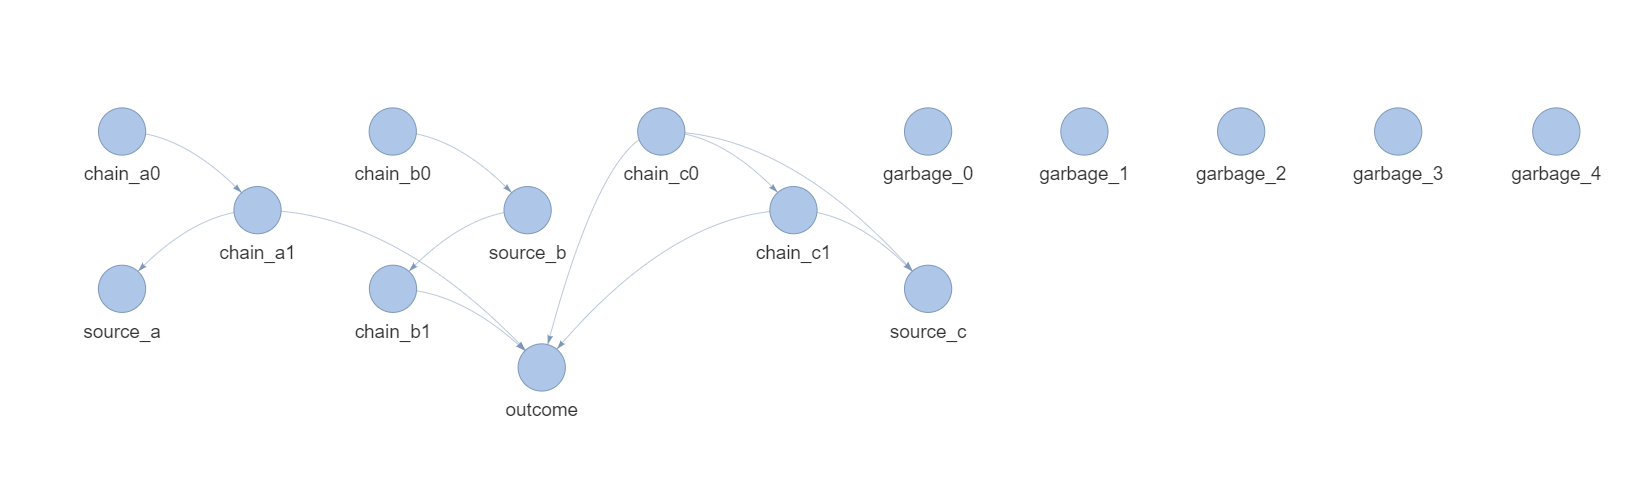

In [ ]:
# марковское покрытие
bn.markov_blanket('outcome')

{'nodes': ['chain_a1', 'chain_c0', 'chain_b1', 'chain_c1', 'outcome'],
 'edges': [['chain_a1', 'outcome'],
  ['chain_b1', 'outcome'],
  ['chain_c0', 'chain_c1'],
  ['chain_c0', 'outcome'],
  ['chain_c1', 'outcome']]}

In [ ]:
# нет return (хз почему)
bn.find_family('outcome')

In [ ]:
data_train.head(1)

,source_a,chain_a0,chain_a1,source_b,chain_b0,chain_b1,source_c,chain_c0,chain_c1,outcome,garbage_0,garbage_1,garbage_2,garbage_3,garbage_4
9254,0.0,1.0,0.097,0.383838,0.002632,0.928321,0.76154,0.179371,0.846375,0.847114,0.052362,0.375,0.626104,0.292929,0.227357


In [ ]:
dct = {
    'chain_a1': 0.095,
    'chain_c0': 0.1853,
    'chain_b1': 0.903661,
    'chain_c1': 0.796977
}

# return mean, cov, priors
bn.get_dist('outcome', dct)

(array([[0.79717722],
        [0.79703929],
        [0.        ],
        [0.79710829],
        [0.79772592],
        [0.79694232],
        [0.7973279 ],
        [0.80726436]]),
 array([[[9.21828669e-11]],
 
        [[2.60234891e-11]],
 
        [[0.00000000e+00]],
 
        [[1.91758282e-11]],
 
        [[1.73959955e-11]],
 
        [[7.88866407e-08]],
 
        [[6.80087477e-08]],
 
        [[7.52878021e-08]]]),
 array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 8.44420928e-176,
        0.00000000e+000, 0.00000000e+000, 1.00000000e+000, 0.00000000e+000]))

# Fit Predict: outcome

In [ ]:
# bn.set_classifiers(classifiers={'age': DecisionTreeClassifier(),
#                          'relation': RandomForestClassifier(),
#                          'is_driver': KNeighborsClassifier(n_neighbors=2)})
bn.set_regressor(regressors={'source_a': RandomForestRegressor(),
                              'chain_a1': RandomForestRegressor(),
                              'chain_a0': RandomForestRegressor(),
                              'source_b': RandomForestRegressor(),
                              'chain_b0': RandomForestRegressor(),
                              'chain_b1': RandomForestRegressor(),
                              'source_c': RandomForestRegressor(),
                              'chain_c0': RandomForestRegressor(),
                              'chain_c1': RandomForestRegressor()
                              })

In [ ]:
data_test

,source_a,chain_a0,chain_a1,source_b,chain_b0,chain_b1,source_c,chain_c0,chain_c1,garbage_0,garbage_1,garbage_2,garbage_3,garbage_4
6252,1.00,0.000000,0.00000,0.222222,0.004545,0.928321,0.263915,0.621790,0.844572,0.751330,0.375,0.582966,0.050505,0.461111
4684,0.25,0.277632,1.00000,0.878788,0.001149,0.928321,0.011747,0.217640,0.846416,0.948621,0.750,0.858203,0.969697,0.710197
1731,0.75,0.155976,0.07741,0.000000,0.000000,0.928321,0.618257,0.063713,0.846289,0.628594,0.125,0.096475,0.828283,0.653875
4742,1.00,0.000000,0.00000,0.161616,0.006250,0.928321,0.925948,0.314209,0.846577,0.478677,0.500,0.298032,0.535354,0.548692
4521,1.00,0.000000,0.00000,0.808081,0.001250,0.928321,0.956788,0.337807,0.846639,0.295752,0.500,0.389884,0.202020,0.532621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6412,0.25,0.277632,1.00000,0.191919,0.005263,0.928321,0.078518,0.324654,0.846603,0.564050,0.875,0.420247,0.303030,0.978182
8285,0.25,0.277632,1.00000,0.848485,0.001190,0.928321,0.470937,0.953586,0.845807,0.690820,0.250,0.130504,0.424242,0.629032
7853,0.00,1.000000,0.09700,0.484848,0.002083,0.928321,0.373886,0.798042,0.845621,0.365250,0.750,0.809520,0.353535,0.952954
1095,1.00,0.000000,0.00000,0.282828,0.003571,0.928321,0.912708,0.303873,0.846554,0.286241,0.875,0.927155,0.323232,0.405506


In [ ]:
bn.fit_parameters(data_train)

In [ ]:
# parall_count is the number of parallel threads to use
predictions = bn.predict(test=data_test, parall_count=4)

100%|██████████| 2000/2000 [00:45<00:00, 44.01it/s]


In [ ]:
# np.nan_to_num(np.array(predictions['outcome']), 0.0)

array([0.44749703, 0.92817118, 0.55615583, ..., 0.31376802, 0.57686266,
       0.70881429])

In [ ]:
# mean_squared_error(target_test.values, np.array(predictions['outcome']))
# mean_squared_error(target_test.values, np.nan_to_num(np.array(predictions['outcome']), 0.0))

0.08516416200458742

In [ ]:
# r2_score(target_test.values, np.array(predictions['outcome']))
# r2_score(target_test.values, np.nan_to_num(np.array(predictions['outcome']), 0.0))

0.26841753823043957

In [ ]:
def nrmse_score(true: np.array, pred: np.array):
  if len(true) != len(pred):
    err_msg = f'Length mismatch: {len(true)=}, {len(pred)=}'
    raise ValueError(err_msg)
  if (len(true.shape) > 1) or (len(pred.shape) > 1):
    err_msg = f'Invalid dimensions: {true.shape=}, {pred.shape=}'
    err_msg += '\nProvide 1-D arrays only.'
    raise ValueError(err_msg)
  if len(true) == 1:
    return abs(pred - true) / abs(true)
  if len(np.unique(true)) == 1:
    return abs(pred.mean() - true.mean()) / abs(true.mean())
  nrmse = mean_squared_error(
    normalize(true),
    normalize(pred, min_=true.min(), max_=true.max()),
    squared=False
  )
  return nrmse


In [ ]:
nrmse_score(target_test.values, np.array(predictions['outcome']))

0.00023710808061198338

In [ ]:
# used regressors
nrmse_score(target_test.values, np.array(predictions['outcome']))

0.01204446042945351

In [ ]:
np.array(predictions['outcome'])

array([0.84445566, 0.84653866, 0.84631069, ..., 0.84587164, 0.84643751,
       0.84866001])

In [ ]:
target_test.values

array([0.84445924, 0.84653583, 0.84630264, ..., 0.84635886, 0.8464398 ,
       0.84866043])

# Fit Predict: magnitude, outcome

In [ ]:
data_train, data_test = train_test_split(df_norm, test_size=0.2, random_state=42)

target_test_outcome = data_test['outcome']
target_test_magnitude = data_test['magnitude']


data_test = data_test.drop(columns=['outcome', 'magnitude'])

In [ ]:
data_test.head()

,depends_on_magnitude,switch,garbage_0,garbage_1,garbage_2
6252,0.000076,0.5,0.764610,0.995184,0.278373
4684,0.999514,0.5,0.860646,0.986034,0.241520
1731,0.250121,0.5,0.053217,0.032447,0.851801
4742,0.249956,0.5,0.840527,0.957918,0.200079
4521,0.500046,0.5,0.106567,0.044803,0.049821


In [ ]:
bn.fit_parameters(data_train)

In [ ]:
# parall_count is the number of parallel threads to use
predictions = bn.predict(test=data_test, parall_count=4)

100%|██████████| 2000/2000 [00:59<00:00, 33.52it/s]


In [ ]:
mean_absolute_percentage_error(target_test_outcome.values, np.array(predictions['outcome']))

0.05158965738762896

In [ ]:
mean_absolute_percentage_error(target_test_magnitude.values, np.array(predictions['magnitude']))

236266577013718.66

In [ ]:
np.unique(np.array(predictions['outcome']))

array([6.22605644e-04, 6.29802171e-04, 6.48802919e-04, ...,
       9.91424465e-01, 9.91426481e-01, 9.91432304e-01])

# Fit Predict: magnitude

In [ ]:
data_train, data_test = train_test_split(df_norm, test_size=0.2, random_state=42)

target_test_magnitude = data_test['magnitude']


data_test = data_test.drop(columns=['magnitude'])

In [ ]:
data_test.head()

,depends_on_magnitude,switch,garbage_0,garbage_1,garbage_2,outcome
6252,0.000076,0.5,0.764610,0.995184,0.278373,0.001085
4684,0.999514,0.5,0.860646,0.986034,0.241520,0.998640
1731,0.250121,0.5,0.053217,0.032447,0.851801,0.249964
4742,0.249956,0.5,0.840527,0.957918,0.200079,0.249673
4521,0.500046,0.5,0.106567,0.044803,0.049821,0.500201


In [ ]:
bn.fit_parameters(data_train)

In [ ]:
# parall_count is the number of parallel threads to use
predictions = bn.predict(test=data_test, parall_count=4)

100%|██████████| 2000/2000 [00:49<00:00, 40.39it/s]


In [ ]:
mean_absolute_percentage_error(target_test_magnitude.values, np.array(predictions['magnitude']))

236266577013718.66

In [ ]:
np.unique(np.array(predictions['magnitude']))

array([0.49492188])

# Fit Predict: dep_on_magnitude, outcome

In [ ]:
data_train, data_test = train_test_split(df_norm, test_size=0.2, random_state=42)

target_test_outcome = data_test['outcome']
target_test_depends_on_magnitude = data_test['depends_on_magnitude']


data_test = data_test.drop(columns=['outcome', 'depends_on_magnitude'])

In [ ]:
data_test.head()

,magnitude,switch,garbage_0,garbage_1,garbage_2
6252,0.00,0.5,0.764610,0.995184,0.278373
4684,1.00,0.5,0.860646,0.986034,0.241520
1731,0.25,0.5,0.053217,0.032447,0.851801
4742,0.25,0.5,0.840527,0.957918,0.200079
4521,0.50,0.5,0.106567,0.044803,0.049821


In [ ]:
bn.fit_parameters(data_train)

In [ ]:
# parall_count is the number of parallel threads to use
predictions = bn.predict(test=data_test, parall_count=4)

100%|██████████| 2000/2000 [01:06<00:00, 30.18it/s]


In [ ]:
# mean_absolute_percentage_error(target_test_outcome.values, np.array(predictions['outcome']))
mean_squared_error(target_test_outcome.values, np.array(predictions['outcome']))

2.6724949650286767e-07

In [ ]:
# mean_absolute_percentage_error(target_test_depends_on_magnitude.values, np.array(predictions['depends_on_magnitude']))
mean_squared_error(target_test_depends_on_magnitude.values, np.array(predictions['depends_on_magnitude']))

1.3028923736380628e-07

In [ ]:
np.unique(np.array(predictions['depends_on_magnitude']))

array([6.26507637e-04, 1.25472584e-01, 2.50304142e-01, 3.75133255e-01,
       4.99990522e-01, 6.24842927e-01, 7.49676839e-01, 8.74532434e-01,
       9.99382601e-01])

# Sampling

In [ ]:
bn.sample(10)

100%|██████████| 10/10 [00:00<00:00, 253.09it/s]


,Feofan,Glafira,Lev,Masha,Bob,Skovoroda,Annigilyatornaya Pushka,Vasiliy,Topaz,outcome
0,-0.259715,2,0.674441,1,8,6,0,3,4,0.713870
1,-0.871346,5,0.572750,0,0,4,5,4,1,-0.048729
2,0.915426,6,10.000000,3,8,5,7,1,5,10.841471
3,0.867578,5,10.000000,1,5,3,8,8,5,10.989358
4,0.827669,3,0.147918,5,4,4,3,7,4,1.229737
5,0.656987,4,10.000000,8,5,3,8,7,5,10.656987
6,0.926246,1,0.010784,7,2,1,4,1,6,1.008138
7,0.788758,1,0.003857,8,7,7,8,1,0,0.841471
8,0.935382,0,0.148824,4,1,5,7,8,6,1.156025


In [ ]:
df.sample()

,Feofan,Glafira,Lev,Masha,outcome,Topaz,Bob,Vasiliy,Skovoroda,Annigilyatornaya Pushka
4255,-0.756802,8,0.166667,7,-0.590136,6,6,4,8,7


In [ ]:
df.iloc[0:7, 0:10]

,Feofan,Glafira,Lev,Masha,outcome,Topaz,Bob,Vasiliy,Skovoroda,Annigilyatornaya Pushka
0,-0.756802,8,0.142857,3,-0.613945,7,5,4,8,2
1,0.989358,7,0.125000,5,1.114358,8,1,8,8,3
2,5.000000,5,0.572750,7,5.572750,4,1,0,1,4
3,-0.756802,6,0.572750,1,-0.184052,4,6,4,5,3
4,-0.756802,4,0.708073,8,-0.048729,1,7,4,7,3
5,0.989358,5,0.019915,0,1.009273,3,0,8,5,3
6,0.909297,4,0.572750,3,1.482047,4,5,2,4,4


In [ ]:
bn.predict(df.iloc[0:7, 0:9], parall_count=4)

100%|██████████| 7/7 [00:00<00:00, 19.98it/s]


{'Annigilyatornaya Pushka': ['7', '7', '7', '7', '7', '7', '7']}

# Test 1

In [ ]:
import pandas as pd
import numpy as np


N_GARBAGE = 5

start_1 = np.random.normal(0, 1, 1000)
start_2 = np.random.exponential(1/0.5, 1000)

dep_on_1 = np.sin(start_1) + np.random.rand(len(start_1)) / 10
dep_on_dep_on_1 = dep_on_1 ** 3 + np.random.rand(len(start_1)) / 10

dep_on_2 = start_2 * 15 + np.random.rand(len(start_2)) / 10

outcome = dep_on_dep_on_1 + dep_on_2 + np.random.rand(len(dep_on_2)) / 10

switch = np.ones_like(dep_on_2)

letters = ['G', 'P', 'F', 'Z', 'R']
garbage = {f'{letter}': np.random.random(len(dep_on_2)) for letter, i in zip(letters, range(N_GARBAGE))}

In [ ]:
df = pd.DataFrame(
    {
        'A': start_1,
        'M': start_2,
        'S': dep_on_1,
        'J': dep_on_dep_on_1,
        'T': dep_on_2,
        'D': switch,
        **garbage,
        'outcome': outcome
    }
)
df

,A,M,S,J,T,D,G,P,F,Z,R,outcome
0,-0.832224,1.874436,-0.666819,-0.200782,28.185209,1.0,0.615396,0.304912,0.119032,0.510211,0.216634,27.999217
1,-3.200330,0.574147,0.074473,0.069620,8.712169,1.0,0.941181,0.469725,0.714357,0.519847,0.282474,8.813072
2,0.490766,2.829298,0.522541,0.231948,42.496009,1.0,0.732166,0.824669,0.141439,0.301211,0.093187,42.742545
3,-1.429594,0.177368,-0.952729,-0.847029,2.666875,1.0,0.179997,0.233049,0.746534,0.125209,0.805321,1.849707
4,-0.574493,0.846469,-0.496519,-0.064664,12.720896,1.0,0.189799,0.686091,0.845710,0.756188,0.104119,12.731045
...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.946900,0.747951,-0.722347,-0.301065,11.251802,1.0,0.110130,0.915793,0.512806,0.722742,0.823878,11.038935
996,0.170934,5.846627,0.238924,0.078394,87.793904,1.0,0.582356,0.034584,0.045775,0.372583,0.358441,87.935218
997,-1.027304,2.020498,-0.835025,-0.512347,30.373627,1.0,0.216522,0.540118,0.113972,0.012508,0.138114,29.940198
998,-1.431296,0.044987,-0.915405,-0.726160,0.702989,1.0,0.148139,0.453615,0.759689,0.314188,0.637909,0.066976


<Axes: xlabel='M'>

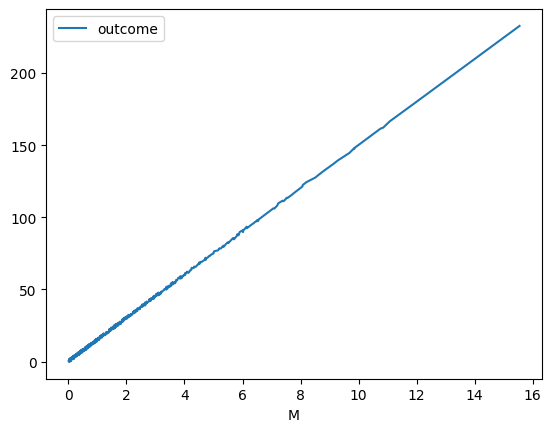

In [ ]:
df.sort_values('M').plot(x='M', y='outcome')

In [ ]:
df.to_csv('test_1.csv')

# Тест 2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


N_GARBAGE = 3

start_1 = np.random.normal(0, 1, 1000)
start_2 = np.random.exponential(1/0.5, 1000)
start_3 = np.random.normal(10, 15, 1000)
start_4 = np.random.exponential(1, 1000)

dep_on_1 = np.power(start_1, 2) + np.random.rand(len(start_1)) / 10
dep_on_2 = np.power(start_2, 3) + np.random.rand(len(start_2)) / 10
dep_on_3 = np.power(start_3, 4) + np.random.rand(len(start_2)) / 10
dep_on_4 = np.power(start_4, 5) + np.random.rand(len(start_2)) / 10

dep_on_1_2 = 3 * dep_on_1 + 0.7 * dep_on_2 + np.random.rand(len(start_1)) / 10
dep_on_3_4 = 2 * dep_on_3 + 0.1 * dep_on_4 + np.random.rand(len(start_1)) / 10


outcome = np.power(dep_on_1_2, 3) + np.random.rand(len(start_2)) / 10

switch = np.ones_like(start_1)

letters = ['R', 'X', 'A']
garbage = {f'{letter}': np.random.random(len(dep_on_2)) for letter, i in zip(letters, range(N_GARBAGE))}

In [ ]:
df = pd.DataFrame(
    {
        'V': start_1,
        'N': start_2,
        'D': start_3,
        'T': start_4,
        'Y': dep_on_1,
        'U': dep_on_2,
        'H': dep_on_3,
        'C': dep_on_4,
        'I': dep_on_1_2,
        'O': dep_on_3_4,
        'Q': switch,
        **garbage,
        'outcome': outcome
    }
)
df

,V,N,D,T,Y,U,H,C,I,O,Q,R,X,A,outcome
0,0.833733,0.832985,-4.069390,0.898293,0.704796,0.600002,274.269336,0.673292,2.588428,548.647770,1.0,0.593070,0.434093,0.603413,1.741971e+01
1,-0.676207,4.115151,-13.591568,1.065222,0.496406,69.736209,34125.455695,1.465882,50.401776,68251.104297,1.0,0.910343,0.113777,0.251734,1.280377e+05
2,-0.347409,3.904031,-0.317783,1.421311,0.165784,59.542985,0.028786,5.846859,42.238919,0.689798,1.0,0.349011,0.295250,0.044405,7.535966e+04
3,-0.818797,1.976877,14.749537,0.146242,0.688636,7.739475,47327.530579,0.007920,7.503255,94655.141222,1.0,0.059527,0.095535,0.729332,4.225070e+02
4,2.145730,1.658517,8.649369,1.147286,4.687214,4.632414,5596.866304,2.001614,17.372900,11193.960721,1.0,0.077290,0.964649,0.821380,5.243531e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2.206739,1.269423,11.768425,0.443702,4.959736,2.074796,19181.126138,0.025317,16.427228,38362.264598,1.0,0.194439,0.835290,0.536044,4.432981e+03
996,-0.757682,1.364988,18.597011,0.376711,0.627121,2.612975,119611.451769,0.093188,3.719842,239222.933137,1.0,0.025761,0.673936,0.095428,5.156344e+01
997,2.215680,1.194235,21.561981,1.493448,4.961423,1.713466,216149.802945,7.446696,16.116008,432300.418956,1.0,0.117503,0.568627,0.283304,4.185759e+03
998,1.424866,0.050032,11.058270,1.480819,2.049994,0.092433,14953.761066,7.216641,6.280924,29908.305879,1.0,0.071001,0.821038,0.939176,2.477961e+02


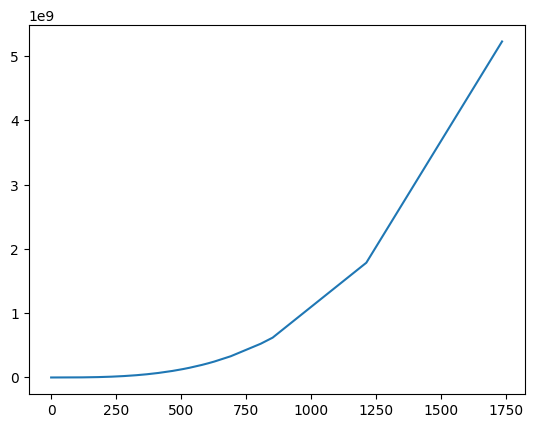

In [ ]:
plt.plot(df.sort_values('I').I, df.sort_values('I').outcome)

In [ ]:
df.to_csv('test_2*.csv')

# Test 3

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


N_GARBAGE = 3

start_1 = np.random.normal(0, 1, 10000)
start_2 = np.random.exponential(1/0.5, 10000)
start_3 = np.random.normal(10, 15, 10000)
start_4 = np.random.exponential(1, 10000)

dep_on_1 = np.power(start_1, 2)
dep_on_2 = np.power(start_2, 3)
dep_on_3 = np.power(start_3, 4)
dep_on_4 = np.power(start_4, 5)

dep_on_1_2 = 3 * dep_on_1 + 0.7 * dep_on_2
dep_on_3_4 = 2 * dep_on_3 + 0.1 * dep_on_4


outcome = np.power(dep_on_1_2, 3)

switch = np.ones_like(start_1)

letters = ['Q', 'W', 'E']
garbage = {f'{letter}': np.random.random(len(dep_on_2)) for letter, i in zip(letters, range(N_GARBAGE))}

In [ ]:
df = pd.DataFrame(
    {
        'R': start_1,
        'T': start_2,
        'L': start_3,
        'K': start_4,
        'H': dep_on_1,
        'A': dep_on_2,
        'Z': dep_on_3,
        'X': dep_on_4,
        'M': dep_on_1_2,
        'N': dep_on_3_4,
        'V': switch,
        **garbage,
        'outcome': outcome
    }
)
df

,R,T,L,K,H,A,Z,X,M,N,V,Q,W,E,outcome
0,-2.280284,0.684166,5.585517,0.088906,5.199697,0.320247,9.733152e+02,0.000006,15.823265,1.946630e+03,1.0,0.342016,0.118942,0.509536,3961.761224
1,1.300111,2.036267,6.377728,0.216860,1.690290,8.443141,1.654490e+03,0.000480,10.981067,3.308979e+03,1.0,0.099490,0.555818,0.234393,1324.139210
2,1.316202,0.686537,-7.858991,0.285661,1.732389,0.323588,3.814760e+03,0.001902,5.423678,7.629521e+03,1.0,0.645095,0.769104,0.843254,159.544448
3,0.652420,0.731427,34.371431,2.515242,0.425652,0.391303,1.395695e+06,100.669655,1.550866,2.791400e+06,1.0,0.172645,0.170011,0.662956,3.730123
4,1.136858,1.253755,7.647689,0.190733,1.292447,1.970777,3.420746e+03,0.000252,5.256885,6.841491e+03,1.0,0.686410,0.845562,0.590813,145.273213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.395147,2.329658,-13.577854,4.681490,1.946434,12.643773,3.398792e+04,2248.641995,14.689944,6.820070e+04,1.0,0.088102,0.927740,0.555526,3170.008696
9996,0.055589,0.907283,32.631361,2.590160,0.003090,0.746842,1.133811e+06,116.582428,0.532060,2.267634e+06,1.0,0.583622,0.177210,0.187013,0.150620
9997,0.787249,1.930557,9.899223,0.688277,0.619761,7.195286,9.602945e+03,0.154460,6.895984,1.920591e+04,1.0,0.833724,0.068889,0.860349,327.935674
9998,-0.582017,1.670289,-0.028219,0.443676,0.338744,4.659879,6.340705e-07,0.017192,4.278148,1.720476e-03,1.0,0.745187,0.076766,0.804557,78.301025


In [ ]:
df.to_csv('test_3_10000.csv')

# Test 4

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


N_GARBAGE = 3


start_1 = np.random.normal(0, 1, 10000) # R
start_2 = np.random.exponential(1/0.5, 10000) # T
start_3 = np.random.normal(10, 15, 10000) # L
start_4 = np.random.exponential(1, 10000) # K

dep_on_1 = np.power(start_1, 2) # H
dep_on_2 = np.power(start_2, 3) # A
dep_on_3 = np.power(start_3, 4) # Z
dep_on_4 = np.power(start_4, 5) # X

dep_on_1_2 = 3 * dep_on_1 + 0.7 * dep_on_2 # M
dep_on_3_4 = 2 * dep_on_3 + 0.1 * dep_on_4 # N


outcome = np.sin(dep_on_1_2)

switch = np.ones_like(start_1)

letters = ['Q', 'W', 'E']
garbage = {f'{letter}': np.random.random(len(dep_on_2)) for letter, i in zip(letters, range(N_GARBAGE))}

In [ ]:
df = pd.DataFrame(
    {
        'R': start_1,
        'T': start_2,
        'L': start_3,
        'K': start_4,
        'H': dep_on_1,
        'A': dep_on_2,
        'Z': dep_on_3,
        'X': dep_on_4,
        'M': dep_on_1_2,
        'N': dep_on_3_4,
        'V': switch,
        **garbage,
        'outcome': outcome
    }
)
df

,R,T,L,K,H,A,Z,X,M,N,V,Q,W,E,outcome
0,1.277376,0.635078,10.765156,2.078949,1.631688,0.256143,1.343017e+04,3.883466e+01,5.074365,2.686422e+04,1.0,0.439735,0.870583,0.174962,-0.935199
1,-1.358035,1.062417,-13.426960,0.322172,1.844260,1.199182,3.250205e+04,3.470874e-03,6.372207,6.500410e+04,1.0,0.838588,0.391943,0.795456,0.088904
2,0.918251,1.366618,27.133054,0.009323,0.843184,2.552356,5.419943e+05,7.044201e-11,4.316202,1.083989e+06,1.0,0.429125,0.857554,0.451748,-0.922539
3,-0.451287,3.061013,8.264777,0.276375,0.203660,28.681084,4.665783e+03,1.612473e-03,20.687738,9.331567e+03,1.0,0.407718,0.542667,0.767769,0.964465
4,-0.114656,0.657021,2.092197,0.079034,0.013146,0.283620,1.916066e+01,3.083620e-06,0.237972,3.832132e+01,1.0,0.049635,0.473073,0.165629,0.235733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-1.270222,2.885432,7.286093,0.774109,1.613464,24.023287,2.818246e+03,2.779778e-01,21.656692,5.636519e+03,1.0,0.448210,0.962819,0.345613,0.328256
9996,0.798045,0.605743,-5.253226,0.574532,0.636876,0.222262,7.615605e+02,6.259945e-02,2.066211,1.523127e+03,1.0,0.576272,0.765705,0.058587,0.879772
9997,1.410802,3.238924,9.961374,1.369561,1.990361,33.978347,9.846389e+03,4.818453e+00,29.755927,1.969326e+04,1.0,0.337320,0.946954,0.859245,-0.996024
9998,0.218702,1.520235,6.268566,1.617189,0.047831,3.513435,1.544091e+03,1.106125e+01,2.602896,3.089288e+03,1.0,0.275847,0.610146,0.626161,0.513017


In [ ]:
df_norm.to_csv('test_sin.csv')

# Test 5

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

A = np.random.randint(0, 10, 10000)
Q = np.power(A, 3)
M = A * 4 + Q
T = np.sin(M)
S = np.sqrt(T + 1)
K = np.where(M > 300, 1, 0)

W = np.random.randint(53, 100, 10000)
N = W / 10

G = np.ones_like(A)

In [ ]:
df = pd.DataFrame(
    {
        'A': A,
        'Q': Q,
        'M': M,
        'T': T,
        'outcome': S,
        'K': K,
        'W': W,
        'N': N,
        'G': G
    }
)
df['A'] = df['A'].astype(float)
df['Q'] = df['Q'].astype(float)
df['M'] = df['M'].astype(float)
df['W'] = df['W'].astype(float)
df.head()

,A,Q,M,T,outcome,K,W,N,G
0,5.0,125.0,145.0,0.467745,1.211505,0,80.0,8.0,1
1,8.0,512.0,544.0,-0.483344,0.718788,1,89.0,8.9,1
2,2.0,8.0,16.0,-0.287903,0.843858,0,74.0,7.4,1
3,6.0,216.0,240.0,0.945445,1.394792,0,62.0,6.2,1
4,8.0,512.0,544.0,-0.483344,0.718788,1,81.0,8.1,1


In [ ]:
df_norm = df.copy()
for column in df:
  df_norm[column] = normalize(df_norm[column])
df_norm = df_norm.fillna(0.5)
df_norm.head()

,A,Q,M,T,outcome,K,W,N,G
0,0.555556,0.171468,0.189542,0.747371,0.862990,0.0,0.586957,0.586957,0.5
1,0.888889,0.702332,0.711111,0.262998,0.507408,1.0,0.782609,0.782609,0.5
2,0.222222,0.010974,0.020915,0.362533,0.597669,0.0,0.456522,0.456522,0.5
3,0.666667,0.296296,0.313725,0.990655,0.995264,0.0,0.195652,0.195652,0.5
4,0.888889,0.702332,0.711111,0.262998,0.507408,1.0,0.608696,0.608696,0.5


In [ ]:
df_norm.to_csv('test_7.csv')

In [ ]:
pd.read_csv('test_6.csv')

,Unnamed: 0,A,Q,M,T,outcome,K,W,N,G
0,0,1.000000,1.000000,0.999927,0.001070,0.027949,1.0,0.391304,0.391304,0.5
1,1,1.000000,1.000000,0.999931,0.001178,0.029551,1.0,0.608696,0.608696,0.5
2,2,0.444444,0.087791,0.104564,0.002951,0.049505,0.0,0.260870,0.260870,0.5
3,3,0.555556,0.171468,0.189528,0.742886,0.861171,0.0,0.304348,0.304348,0.5
4,4,0.111111,0.001372,0.006606,0.029114,0.166258,0.0,0.260870,0.260870,0.5
...,...,...,...,...,...,...,...,...,...,...
9995,9995,1.000000,1.000000,0.999901,0.000522,0.018218,1.0,0.369565,0.369565,0.5
9996,9996,0.777778,0.470508,0.484971,0.673237,0.819552,1.0,0.826087,0.826087,0.5
9997,9997,0.444444,0.087791,0.104660,0.000274,0.012124,0.0,0.760870,0.760870,0.5
9998,9998,0.333333,0.037037,0.051045,0.995603,0.997787,0.0,0.108696,0.108696,0.5
